# Image Analysis and Processing
## Assignment 1
### Exercise 5

#### Andrinopoulou Christina (ds2200013)
#### Kalimeris Alexandros (ds1200003)

The code for this exercise is based on the code that was provided in the lectures of the course.

In [1]:
from PIL import Image
import cv2 as cv
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from skimage import metrics as metric
import warnings
warnings.filterwarnings('ignore')   # to avoid printout of warnings

In this exercise we have to guess the processing steps one combined so as to create image 2 from image 1. First of all, we can notice that image 2 is complementary to image 1. Also, image 2 contains noise compared to image 1 and has a different dynamic range and brightness. So, we are going to create a pipeline that contains some spatial enhancement methods in order to create image 2 based on image 1.

We utilize a specific measure in order to examine the similarity between the target image and the images that we get after the application of a set of transformations. We believe that this kind of comparison is more accurate than the comparison that we can do based only on the images. In particular, we use the *structural similarity measure*. This measure is a very popular measure for image comparison that was introduced in 2004. For more details, you can check the paper "Image Quality Assessment: From Error Visibility to Structural Similarity" (https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf) that refers to this measure in details. 

(<AxesSubplot:title={'center':'Image 2'}>,
 (-0.5, 799.5, 640.5, -0.5),
 Text(0.5, 1.0, 'Image 2'))

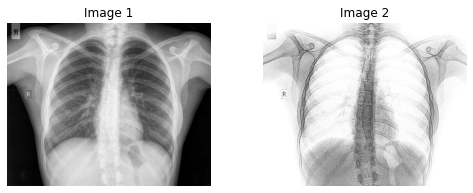

In [2]:
initial_image = Image.open("image_1.jpg")
target_image = Image.open("image_2.jpg")
fig, axes = plt.subplots(1, 2, figsize=(13,3))
plt.subplot(131), plt.imshow(initial_image, cmap='gray'), plt.axis('off'), plt.title('Image 1')
plt.subplot(132), plt.imshow(target_image, cmap='gray'), plt.axis('off'), plt.title('Image 2')

### Pipeline

The pipeline that we use so as to create the second image based on the first image contains the following steps:

- **We apply a high pass filter:**\
High pass filters reduce the low-frequency information and preserve the high-pass information. "High frequency" in a grayscale image means large changes in gray values at a small space. We use this kind of filter in order to designate the details that Image 2 has. At this point, we should emphasize that we use a $3\times 3$ filter-kernel because we want to capture the details of the image as much as we can. The filter has the form:

\begin{bmatrix}
-1 & -1 & -1\\
-1 & z & -1 \\
-1 & -1 & -1
\end{bmatrix}

- **We do Gamma Correction:**\
Generally, cameras and the human's visual system do not operate in the same way. Our visual system is more sensitive to changes in the dark tones. Gamma Correction, also known as *Power Law Transform* is a way to correct the differences between what a camera can capture and what human eyes can see. The image after the gamma correction is transformed based on the formula: $O = I^{\frac{1}{\gamma}}$, where $O$ is the transformed image and $I$ is the initial image. If $\gamma > 1$, the transformed image is lighter compared to the initial one and the opposite if $\gamma < 1$. We use gamma correction after the application of the high pass filter, with $\gamma < 1$. In this way, we create a darker image, because dark pixels are mapped to a bigger set. 

- **We take the complement of the grayscale image**:\
Finally, we subtract from 255 the image values in order to create the complement of the picture.

The function *adjust_gamma* was provided in the lectures of this course and it is used for the Gamma Correction.

In [3]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv.LUT(image, table)

The function *unsharp* was provided in the lectures of this course and it is used for the unsharp masking.

In [4]:
def unsharp(alpha=0.2):
    A1 = np.array([[-1,1,-1],[1,1,1],[-1,1,-1]])
    A2 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return (alpha*A1+A2)/(alpha+1)

The function *histogram_of_image* creates a histogram, which shows the frequency of each brightness value from 0 to 255 in an image. We use these histograms for our images so as to check after the pipelines the results of them.

In [5]:
def histogram_of_image(image, tlt='Image', logscale=False):
    fig, axes = plt.subplots(1, 2, figsize=(13,3))
    plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title(tlt), plt.axis('off')

    plt.subplot(122)
    hist = np.bincount(image[:,:].ravel(), minlength=256) 
    plt.plot(hist), plt.xlim([0,256]), plt.title('Histogram')
    if logscale:
        plt.yscale('log')
    plt.show()

The function *pipeline* implements the pipeline that we have already discussed and returns the similarity measure between the target image (which in this case is the image 2) and image that we created after the transformations that we applied. Also, it returns the transformed image.

In [6]:
def pipeline(initial_image, target_image, alpha=0.1, z=11, gamma=0.5, plot_flag=True, unsharp_mask=False):

    if plot_flag:
        ig, axes = plt.subplots(1, 4, figsize=(15,7))
        
    res = initial_image
    if plot_flag:
        plt.subplot(141), plt.imshow(res, cmap='gray'), plt.title('Initial Image'), plt.axis('off')
        
    if unsharp_mask:
        # unsharp masking
        kernel = unsharp(alpha)
    else:
        # high pass filter
        kernel = -np.ones((3,3),np.float32)
        kernel[1,1] = kernel[1,1]*(-z)
    res = cv.filter2D(res, -1, kernel, cv.BORDER_REFLECT)
    if plot_flag:
        plt.subplot(142), plt.imshow(res, cmap='gray'), plt.title('Step 1'), plt.axis('off')
    
    # gamma correction
    res = adjust_gamma(res, gamma=gamma)
    if plot_flag:
        plt.subplot(143), plt.imshow(res, cmap='gray'), plt.title('Step 2'), plt.axis('off')
    
    # complementary image
    res = (255-res)
    if plot_flag:
        plt.subplot(144), plt.imshow(res, cmap='gray'), plt.title('Step 3'), plt.axis('off')

    if plot_flag:
        ig, axes = plt.subplots(1, 2, figsize=(15,7))
        plt.subplot(121), plt.imshow(target_image, cmap='gray'), plt.title('Target Image'), plt.axis('off')
        plt.subplot(122), plt.imshow(res, cmap='gray'), plt.title('Result of the pipeline'), plt.axis('off')
        plt.show()
    
    similarity = metric.structural_similarity(target_image.astype('float'),res.astype('float'))
    return similarity, res

The aforementioned pipeline needs some parameters: a value $z$ for the high pass filter and a value for the gamma correction. We implement the function *find_best_params* that calls the function *pipeline*, using different combinations of these two parameters. The goal here is to find the best combination of the parameters, which means the combination that creates the best image.

In [7]:
def find_best_params(initial_image, target_image, unsharp=False):
    best_similarity = 0
    best_gamma = 0
    
    if unsharp:
        best_alpha = 0
        list_of_number = [i for i in np.arange(0.1, 3.1, 0.1)]
    else:
        best_z = 0
        list_of_number = [i for i in np.arange(7.9, 10, 0.1)]
    
    for alpha_or_z in list_of_number:
        for gamma in np.arange(0.1, 0.5, 0.1):
            similarity, _ = pipeline(initial_image, target_image, 
                                     alpha=alpha_or_z, z=alpha_or_z, 
                                     gamma=gamma, 
                                     plot_flag=False,
                                    unsharp_mask=unsharp)
            if similarity > best_similarity:
                best_similarity = similarity
                best_z = alpha_or_z
                best_gamma = gamma
                best_alpha = alpha_or_z
    return best_similarity, best_z, best_gamma, best_alpha

We read image 1, which is the initial image for our implementation and image 2, which is the target image and we create the corresponding histograms. We can notice that the tonal range for the target image is around the 250 value. The goal after the pipeline is to have an image with a similar histogram.

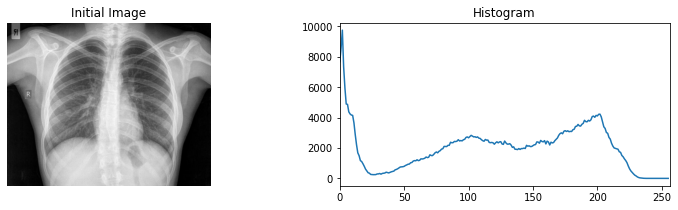

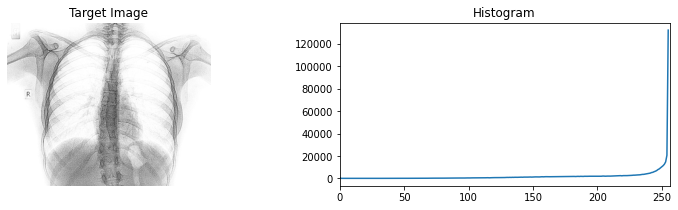

In [8]:
initial_image = cv.imread('image_1.jpg',0) # loads in grayscale
target_image = cv.imread('image_2.jpg',0) # loads in grayscale

histogram_of_image(initial_image, tlt='Initial Image')
histogram_of_image(target_image, tlt='Target Image')

We execute the function *find_best_params* so as to find the optimal combination of the parameters for the pipeline. It seems that the optimal $z$ value for the high pass filter is almost 9 and the optimal value for the gamma is 0.2. This combination of the parameters creates an image that is $86.55\%$ similar to the target image.

Then we call the function *pipeline*, using this combination of the parameters.

**ATTENTION**: The execution of the function may take some seconds!

In [9]:
best_similarity, best_z, best_gamma, _ = find_best_params(initial_image, target_image)
print(f'The best similarity scores is {best_similarity*100}%')
print(f'The optimal value for z is {best_z}')
print(f'The optimal value for gamma is {best_gamma}')

The best similarity scores is 86.55336359974535%
The optimal value for z is 8.999999999999996
The optimal value for gamma is 0.2


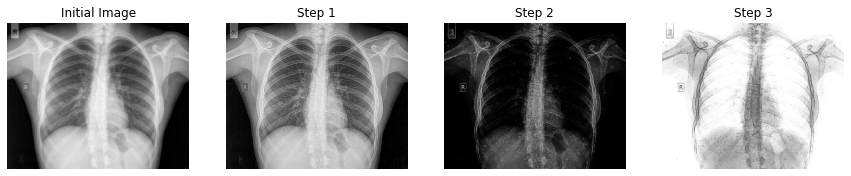

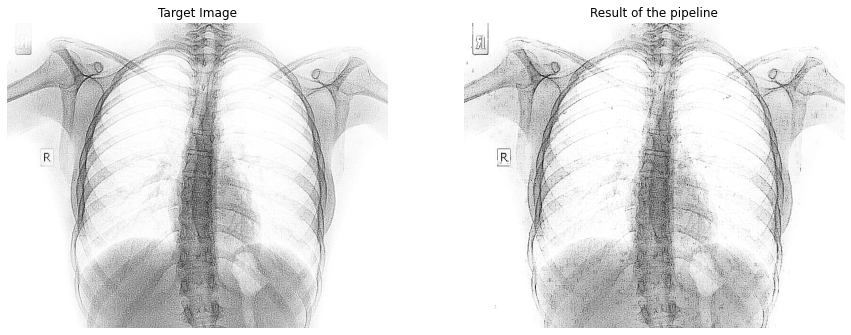

The similarity between the target image and the image after the pipeline is 86.55336359974535%


In [10]:
similarity, res = pipeline(initial_image, target_image, z=9, gamma=0.2)
print(f'The similarity between the target image and the image after the pipeline is {similarity*100}%')

Furthermore, we create the histogram of the image that came from the pipeline. We can notice that the histogram is similar to the target's histogram to a great degree.

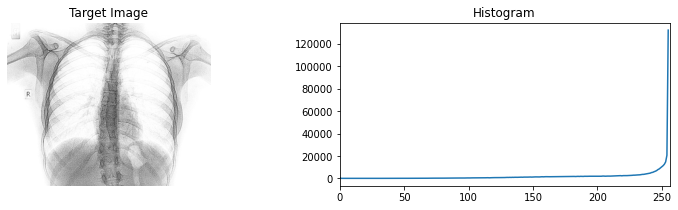

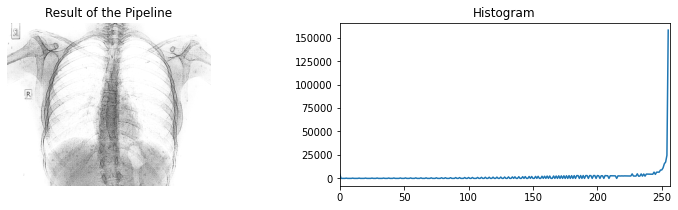

In [11]:
histogram_of_image(target_image, tlt='Target Image')
histogram_of_image(res, tlt='Result of the Pipeline')

We noticed that the previous image that comes from the pipeline that we discussed contains some dark spots. We believe that these spots may affect the quality of the meta-analysis, especially for a medical image. So we tried other pipelines in order to avoid the creation of the spots. After experiments, we concluded that the unsharp mask leads to good results as well. The structural similarity that we achieved as you will see later on is close to the previous one. You will probably have seen that the function *pipeline* takes as input a flag, which refers to the unsharp masking. If this flag is on, the pipeline does the unsharp masking otherwise, it does the high pass filter that we have described. Therefore, instead of applying a high pass filter:\

- **We apply the unsharp mask**:\
The unsharp masking amplifies the high-frequencies. This filter subtracts from the original image an unsharp (blurred) version of the initial image. The filter has the below form:

$$
\frac{1}{α+1} \left[\begin{array}
{rrr}
-α & α-1 & -α \\
α-1 & α+5 & α-1 \\
-α & α-1 & -α
\end{array}\right]
$$

It is obvious that we repeat the same steps as before. First of all, we try to find the optimal combination of the parameters for this version of the pipeline and then we call the function *pipeline*, using these parameters and setting the *unsharp_mask* equal to True.

In [12]:
best_similarity, _, best_gamma, best_alpha = find_best_params(initial_image, target_image, unsharp=True)
print(f'The best similarity scores is {best_similarity*100}%')
print(f'The optimal value for alpha is {best_alpha}')
print(f'The optimal value for gamma is {best_gamma}')

The best similarity scores is 82.35738721814674%
The optimal value for alpha is 0.1
The optimal value for gamma is 0.30000000000000004


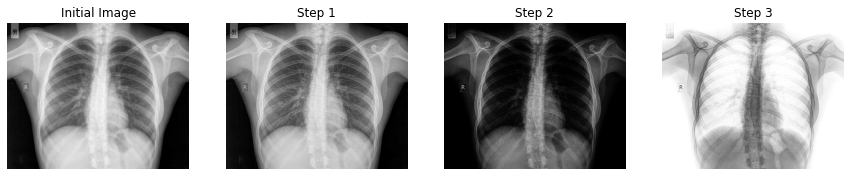

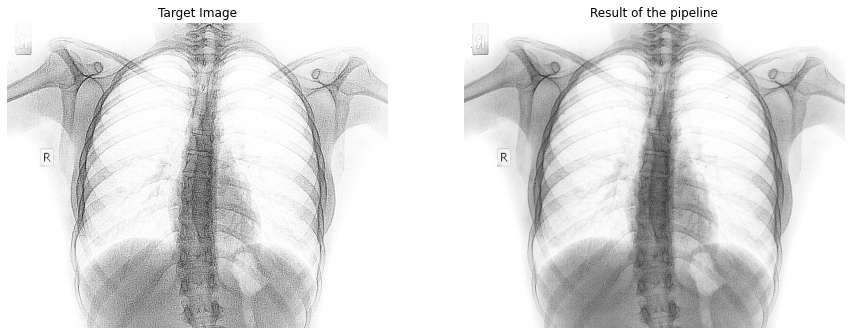

The similarity between the target image and the image after the pipeline is 82.35738721814674%


In [13]:
similarity, res = pipeline(initial_image, target_image, alpha=0.1, gamma=0.3, unsharp_mask=True)
print(f'The similarity between the target image and the image after the pipeline is {similarity*100}%')

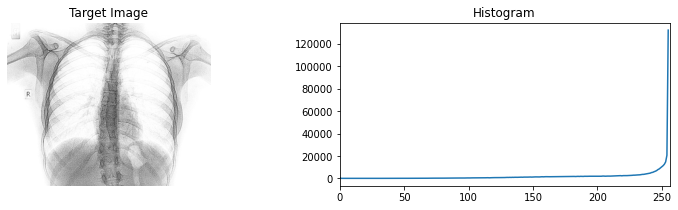

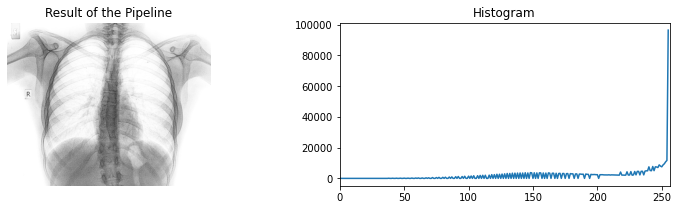

In [14]:
histogram_of_image(target_image, tlt='Target Image')
histogram_of_image(res, tlt='Result of the Pipeline')

As you can see the similarity is close to the previous one and the histogram approaches the histogram of the target image.

## Reverse Pipeline

In this step, we want to do the reverse process. We want to transform image 2 to image 1. We can notice that image 2 is noisy, so we should use the appropriate filters in order to reduce the noise. Also, the target image is complementary to of the initial image. Finally, these two images have differences in brightness. We follow the steps below in order to achieve as much as possible the transformation from one image to another:

- **We apply a Gaussian filter**:\
Gaussian filters are low pass filters. The construction of a gaussian filter is based on a Gaussian probability distribution function. This means that the kernel takes into account the pixels that are more close to the central pixel. Of course, this is based on the standard deviation $\sigma$ of the Gaussian kernel that the user selects. If the standard deviation is small, then the curve that comes from the Gaussian distribution is more concentrated and as a result, the kernel is influenced by the pixels that are near to the central pixel in a greater degree, compared to the pixels that are far away from that. We use this kind of filter so as to reduce the noise that image 1 has.

- **We apply a median filter**:\
Apart from the Gaussian filter, we also apply a median filter. The goal of this step is similar to the previous one. This kind of filter replaces the central pixel with the median of the pixels under the area of the filter. The median filter is very effective in noise reduction and preserves the edges of an image.

- **We take the complement of the grayscale image**:\
After the application of the low pass filters for the reduction of the noise, we take the complementary of the image. As we will see later on in figure "Step 2", the image is very dark, compared to the target image. Therefore, we should apply a transformation in order to make it lighter. 

- **We do Gamma Correction**:\
We apply Gamma correction to the image so as to be lighter. We have already discussed this kind of transformation. Here we set the $\gamma$ to be greater than 1, because in this case, we want a lighter image.

- **We add and subtract values for pixels under a specific threshold**:\
This step increases or decreases the value of some pixels. We experimented ourselves using many different combinations for the thresholds and the values that we add and/or subtract. We conclude that this step increases the achieved similarity to a low degree, but we keep it as a step in the pipeline.

In [15]:
def reverse_pipeline(initial_image, target_image, kernel_size=5, sigma=0, kernel_size_2=5, gamma=1.1, threshold=10, add_value=10, threshold2=10, add_value2=10, plot_flag=True):

    if plot_flag:
        ig, axes = plt.subplots(1, 6, figsize=(15,7))
        
    res = initial_image
    if plot_flag:
        plt.subplot(161), plt.imshow(res, cmap='gray'), plt.title('Initial Image'), plt.axis('off')
        
    # guassian filter
    x = cv.getGaussianKernel(kernel_size,sigma)
    gaussian = x*x.T
    res = cv.filter2D(res, -1, gaussian, cv.BORDER_CONSTANT)
    if plot_flag:
        plt.subplot(162), plt.imshow(res, cmap='gray'), plt.title('Step 1'), plt.axis('off')
        
    # median filter
    res = cv.medianBlur(res,kernel_size_2)
    if plot_flag:
        plt.subplot(163), plt.imshow(res, cmap='gray'), plt.title('Step 2'), plt.axis('off')
    
    # complementary
    res = (255-res)  
    if plot_flag:
        plt.subplot(164), plt.imshow(res, cmap='gray'), plt.title('Step 3'), plt.axis('off')
        
    # gamma correction
    res = adjust_gamma(res, gamma=gamma)  
    if plot_flag:
        plt.subplot(165), plt.imshow(res, cmap='gray'), plt.title('Step 4'), plt.axis('off')
    
    res[res<threshold] += add_value
    res[res<threshold2] -= add_value2
    if plot_flag:
        plt.subplot(166), plt.imshow(res, cmap='gray'), plt.title('Step 5'), plt.axis('off')
        plt.show()
        
    if plot_flag:
        ig, axes = plt.subplots(1, 2, figsize=(15,7))
        plt.subplot(121), plt.imshow(target_image, cmap='gray'), plt.title('Target Image'), plt.axis('off')
        plt.subplot(122), plt.imshow(res, cmap='gray'), plt.title('Result of the pipeline'), plt.axis('off')
        plt.show()

    similarity = metric.structural_similarity(target_image.astype('float'),res.astype('float'))
    return similarity, res

The function *best_params_last_step_rev* calls the function *reverse_pipeline*, using different combinations for the parameters of the last step of the pipeline. We did not create a function that finds the best combination of all parameters, because as you can imagine such a function will need hours in order to return an optimal combination of parameters.

In [16]:
def best_params_last_step_rev(initial_image, target_image):

    best_similarity = 0
    best_threshold1 = 0
    best_threshold2 = 0
    best_add_value1 = 0
    best_add_value2 = 0

    for threshold1 in range(10,60,5):
        for add1 in range(10, 50, 10):
            for threshold2 in range(10,50,5):
                for add2 in range(10,50,10):
                    similarity_rev, res_rev = reverse_pipeline(initial_image, target_image, 
                                               kernel_size=7, sigma=1.1, 
                                               gamma=4.1, 
                                               kernel_size_2=3,
                                               threshold=threshold1, add_value=add1,
                                                threshold2=threshold2, add_value2=add2,
                                                plot_flag=False)
                    if similarity_rev > best_similarity:
                        best_similarity = similarity_rev
                        best_threshold1 = threshold1
                        best_threshold2 = threshold2
                        best_add_value1 = add1
                        best_add_value2 = add2
    return best_similarity, best_threshold1, best_threshold2, best_add_value1, best_add_value2

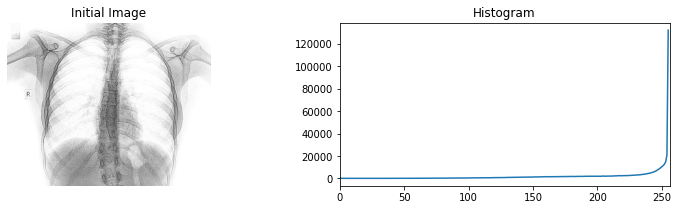

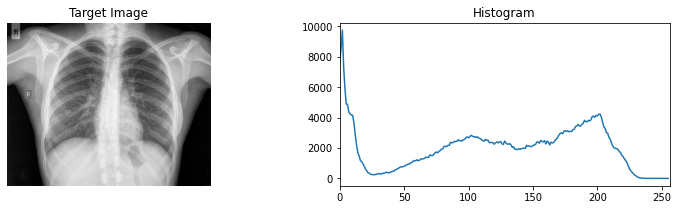

In [17]:
initial_image = cv.imread('image_2.jpg',0) # loads in grayscale
target_image = cv.imread('image_1.jpg',0) # loads in grayscale

histogram_of_image(initial_image, tlt='Initial Image')
histogram_of_image(target_image, tlt='Target Image')

We call the function *best_params_last_step_rev* in order to find the best combination for the last step of the reverse pipeline.

At this point, we should mention that the other parameters of the function *reverse_pipeline* are set to be equal to some values that we understand that are suitable for this particular problem after a lot of experiments.

**ATTENTION**: The execution of the function may take some seconds!

In [18]:
best_similarity, best_threshold1, best_threshold2, best_add_value1, best_add_value2 = best_params_last_step_rev(initial_image, target_image)
print(f'The best similarity scores is {best_similarity*100}%')
print(f'The optimal value for the first threshold is {best_threshold2}')
print(f'The optimal value for the second threshold is {best_threshold1}')
print(f'The optimal value for the first additive value is {best_add_value1}')
print(f'The optimal value for the second additive value is {best_add_value2}')

The best similarity scores is 66.44311074336511%
The optimal value for the first threshold is 10
The optimal value for the second threshold is 10
The optimal value for the first additive value is 40
The optimal value for the second additive value is 10


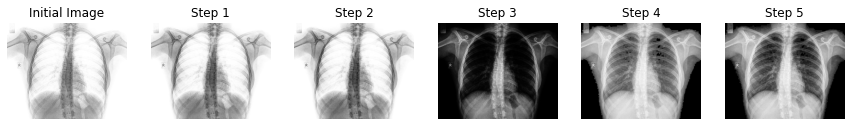

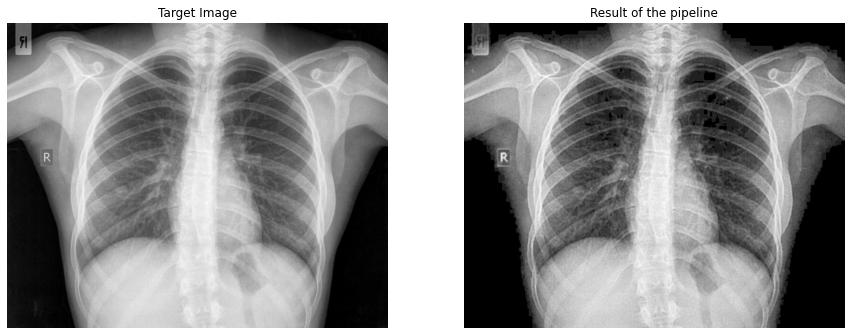

The similarity between the target image and the image after the pipeline is 66.44311074336511%


In [19]:
initial_image = cv.imread('image_2.jpg',0) # loads in grayscale
target_image = cv.imread('image_1.jpg',0) # loads in grayscale

similarity_rev, res_rev = reverse_pipeline(initial_image, target_image, 
                                           kernel_size=7, sigma=1.1, 
                                           gamma=4.1, 
                                           kernel_size_2=3,
                                          threshold=10, add_value=40,
                                          threshold2=10, add_value2=10)
print(f'The similarity between the target image and the image after the pipeline is {similarity_rev*100}%')

The reverse pipeline achieves similarity $66.5\%$, approximately. We can notice that the reverse pipeline needs more steps and achieves less good results. This is because the initial image includes noise that has to be reduced. Furthermore, the image is lighter to a great degree, compared to the initial image of the first pipeline and as a result, some of the information is not accurate so as to achieve in the reverse pipeline the desirable results. Generally, this procedure is much more difficult than a procedure that adds noise to an image. A drawback in our results is that we cannot achieve the "smooth" transition from the light pixels to the dark ones in the border of the human body. We, definitely, understand that we lose some information of the image with the reverse pipeline.\

At this point, we should mention that we utilized many different kinds of low pass filters and transformations in many combinations in order to experiment ourselves and learn more about this specific topic based on these images. However, this pipeline that was our initial approach (with some modifications that we understand that were not effective in this particular case) achieved the best performance.